# _LeNet-5_ CNN Learning Rate Schedulers: MNIST & PyTorch

[Guide to LR Schedulers in PyTorch](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling/notebook)

In [ ]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES = 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

/home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/arjun/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.12.1+cu102


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Number of GPU(s) available = 0
PyTorch does not have access to GPU
Available device is cpu


In [4]:
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

# Apply transforms-
transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [6]:
# MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = '/home/arjun/Downloads/.data', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = '/home/arjun/Downloads/.data', train = False,
        transform = transforms_apply
        )

In [7]:
print(f"len(train_dataset): {len(train_dataset)} & len(test_dataset): {len(test_dataset)}")

len(train_dataset): 60000 & len(test_dataset): 10000


In [8]:
# Hyper-parameters-
num_epochs = 30
batch_size = 256
learning_rate = 0.001

In [10]:
# Create dataloader-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = True
        )

In [11]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 235 & len(test_loader) = 40


In [12]:
# Sanity check-
x, y = next(iter(train_loader))

In [13]:
x.min(), x.max()

(tensor(-0.4242), tensor(2.8215))

In [14]:
x.shape, y.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [15]:
x = x.permute((0, 2, 3, 1))
x.shape

torch.Size([256, 28, 28, 1])

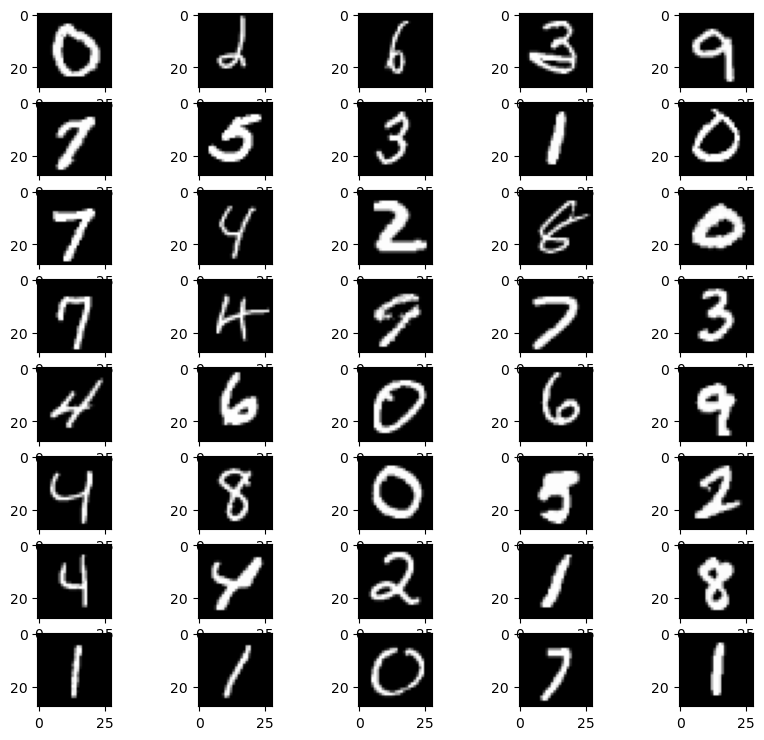

In [16]:
# Print images from training set-
plt.figure(figsize = (10, 9))
for i in range(40):
    plt.subplot(8, 5, i + 1)
    plt.imshow(x[i], cmap = 'gray')
plt.show()

In [17]:
del x, y

### _LeNet-5_ CNN architecture

- Use Batch normalization

- Use Sigmoid Linear Unit (SiLU)

In [18]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6, 
            kernel_size = 5, stride = 1,
            padding = 0, bias = False 
        )
        self.bn1 = nn.BatchNorm2d(num_features = 6)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = 16)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(
            in_features = 256, out_features = 120,
            bias = True
        )
        self.bn3 = nn.BatchNorm1d(num_features = 120)
        self.fc2 = nn.Linear(
            in_features = 120, out_features = 84,
            bias = True
        )
        self.bn4 = nn.BatchNorm1d(num_features = 84)
        self.fc3 = nn.Linear(
            in_features = 84, out_features = 10,
            bias = True
        )
        
        self.initialize_weights()

        
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        x = nn.SiLU()(self.pool1(self.bn1(self.conv1(x))))
        x = nn.SiLU()(self.pool1(self.bn2(self.conv2(x))))
        x = x.view(-1, 256)
        x = nn.SiLU()(self.bn3(self.fc1(x)))
        x = nn.SiLU()(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x
    

In [19]:
# Initialize an instance of LeNet-5 CNN architecture-
model = LeNet5().to(device)

In [20]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

In [21]:
print(f"CNN model has {tot_params} parameters")

CNN model has 44856 parameters


In [22]:
# Define cost function-
loss = nn.CrossEntropyLoss()

In [23]:
# Defing SGD optimizer-
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [24]:
print(f"number of train steps in one epoch = {np.ceil(len(train_loader.dataset) / batch_size)}")

number of train steps in one epoch = 235.0


#### ```MultiStepLR``` PyTorch

```torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=- 1, verbose=False)```

Decays the learning rate of each parameter group by _gamma_ once the number of epoch reaches one of the milestones. Notice that such decay can happen simultaneously with other changes to the learning rate from outside this scheduler. When last_epoch=-1, sets initial lr as lr.


Parameters:

- optimizer (Optimizer) – Wrapped optimizer.
- milestones (list) – List of epoch indices. Must be increasing.
- gamma (float) – Multiplicative factor of learning rate decay. Default: 0.1.
- last_epoch (int) – The index of last epoch. Default: -1.
- verbose (bool) – If True, prints a message to stdout for each update. Default: False.


Example:

```
# Assuming optimizer uses lr = 0.05 for all groups
# lr = 0.05     if epoch < 30
# lr = 0.005    if 30 <= epoch < 80
# lr = 0.0005   if epoch >= 80
scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
```

[MultiStepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html). You might aso consider [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html) scheduler.

In [25]:
# Decay lr at 10th and 20th epochs by a factor of 10-
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer, milestones = [10, 20],
    gamma = 0.1
)

In [26]:
def train_one_step(model, train_loader, train_dataset):
    running_loss = 0.0
    running_corrects = 0.0
    
    model.to(device)
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.detach().cpu().item()


In [27]:
def test_one_step(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0
    
    model.to(device)
    model.eval()

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.detach().cpu().item()


In [28]:
# Python3 dict to contain training metrics-
train_history = {}

In [29]:
# Variable to store 'best' model-
best_val_acc = 0

In [31]:
for epoch in range(1, num_epochs + 1):
    
    # One epoch of training-
    train_loss, train_acc = train_one_step(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    # Get validation metrics after 1 epoch of training-
    val_loss, val_acc = test_one_step(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
    
    scheduler.step()
    
    current_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch: {epoch}; loss = {train_loss:.4f}, acc = {train_acc:.2f}%",
          f" val loss = {val_loss:.4f}, val acc = {val_acc:.2f}% & LR = {current_lr:.5f}"
         )
    
    # Save training metrics to Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss, 'val_loss': val_loss,
        'train_acc': train_acc, 'val_acc': val_acc,
        'lr': current_lr
    }
    
    # Save model with best validation accuracy-
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        torch.save(model.state_dict(), "LeNet5_MNIST_best_val_acc.pth")
        

Training: : 100%|█| 235/235 [00:09<00:00, 24.94batch/s, accuracy=80, loss=0.
Validation: : 100%|█| 40/40 [00:01<00:00, 31.14batch/s, val_acc=89.1, val_lo


Epoch: 1; loss = 0.8244, acc = 80.01%  val loss = 0.5042, val acc = 89.11% & LR = 0.01000
Saving model with highest val_acc = 89.11%



Training: : 100%|█| 235/235 [00:09<00:00, 25.05batch/s, accuracy=90.5, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 32.65batch/s, val_acc=92.5, val_lo


Epoch: 2; loss = 0.4329, acc = 90.48%  val loss = 0.3321, val acc = 92.53% & LR = 0.01000
Saving model with highest val_acc = 92.53%



Training: : 100%|█| 235/235 [00:09<00:00, 25.00batch/s, accuracy=92.9, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 33.59batch/s, val_acc=93.9, val_lo


Epoch: 3; loss = 0.3122, acc = 92.87%  val loss = 0.2588, val acc = 93.89% & LR = 0.01000
Saving model with highest val_acc = 93.89%



Training: : 100%|█| 235/235 [00:09<00:00, 24.99batch/s, accuracy=94.1, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 32.19batch/s, val_acc=94.8, val_lo


Epoch: 4; loss = 0.2503, acc = 94.13%  val loss = 0.2133, val acc = 94.81% & LR = 0.01000
Saving model with highest val_acc = 94.81%



Training: : 100%|█| 235/235 [00:09<00:00, 25.91batch/s, accuracy=94.9, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 32.68batch/s, val_acc=95.3, val_lo


Epoch: 5; loss = 0.2125, acc = 94.94%  val loss = 0.1840, val acc = 95.26% & LR = 0.01000
Saving model with highest val_acc = 95.26%



Training: : 100%|█| 235/235 [00:09<00:00, 25.15batch/s, accuracy=95.5, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 33.54batch/s, val_acc=95.7, val_lo


Epoch: 6; loss = 0.1862, acc = 95.46%  val loss = 0.1644, val acc = 95.71% & LR = 0.01000
Saving model with highest val_acc = 95.71%



Training: : 100%|█| 235/235 [00:09<00:00, 24.65batch/s, accuracy=95.8, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 31.39batch/s, val_acc=96.2, val_lo


Epoch: 7; loss = 0.1674, acc = 95.85%  val loss = 0.1486, val acc = 96.19% & LR = 0.01000
Saving model with highest val_acc = 96.19%



Training: : 100%|█| 235/235 [00:09<00:00, 24.58batch/s, accuracy=96.2, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 33.96batch/s, val_acc=96.6, val_lo


Epoch: 8; loss = 0.1517, acc = 96.19%  val loss = 0.1357, val acc = 96.59% & LR = 0.01000
Saving model with highest val_acc = 96.59%



Training: : 100%|█| 235/235 [00:09<00:00, 25.25batch/s, accuracy=96.5, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 32.47batch/s, val_acc=96.7, val_lo


Epoch: 9; loss = 0.1398, acc = 96.49%  val loss = 0.1260, val acc = 96.74% & LR = 0.01000
Saving model with highest val_acc = 96.74%



Training: : 100%|█| 235/235 [00:09<00:00, 25.03batch/s, accuracy=96.6, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 31.85batch/s, val_acc=97, val_loss


Epoch: 10; loss = 0.1301, acc = 96.61%  val loss = 0.1182, val acc = 96.99% & LR = 0.00100
Saving model with highest val_acc = 96.99%



Training: : 100%|█| 235/235 [00:09<00:00, 25.14batch/s, accuracy=96.8, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 32.99batch/s, val_acc=97, val_loss


Epoch: 11; loss = 0.1247, acc = 96.84%  val loss = 0.1172, val acc = 97.03% & LR = 0.00100
Saving model with highest val_acc = 97.03%



Training: : 100%|█| 235/235 [00:09<00:00, 25.08batch/s, accuracy=96.8, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 33.81batch/s, val_acc=96.9, val_lo


Epoch: 12; loss = 0.1236, acc = 96.85%  val loss = 0.1170, val acc = 96.92% & LR = 0.00100


Training: : 100%|█| 235/235 [00:09<00:00, 25.28batch/s, accuracy=96.9, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 32.26batch/s, val_acc=97, val_loss


Epoch: 13; loss = 0.1225, acc = 96.89%  val loss = 0.1160, val acc = 96.98% & LR = 0.00100


Training: : 100%|█| 235/235 [00:09<00:00, 25.18batch/s, accuracy=96.9, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 33.12batch/s, val_acc=97, val_loss


Epoch: 14; loss = 0.1221, acc = 96.88%  val loss = 0.1150, val acc = 96.98% & LR = 0.00100


Training: : 100%|█| 235/235 [00:09<00:00, 25.23batch/s, accuracy=96.9, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 33.23batch/s, val_acc=97.1, val_lo


Epoch: 15; loss = 0.1209, acc = 96.93%  val loss = 0.1152, val acc = 97.10% & LR = 0.00100
Saving model with highest val_acc = 97.10%



Training: : 100%|█| 235/235 [00:09<00:00, 25.38batch/s, accuracy=96.9, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 32.84batch/s, val_acc=97.1, val_lo


Epoch: 16; loss = 0.1201, acc = 96.88%  val loss = 0.1136, val acc = 97.07% & LR = 0.00100


Training: : 100%|█| 235/235 [00:09<00:00, 25.27batch/s, accuracy=96.9, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 33.29batch/s, val_acc=97.1, val_lo


Epoch: 17; loss = 0.1200, acc = 96.92%  val loss = 0.1129, val acc = 97.10% & LR = 0.00100


Training: : 100%|█| 235/235 [00:09<00:00, 25.34batch/s, accuracy=96.9, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 33.04batch/s, val_acc=97.1, val_lo


Epoch: 18; loss = 0.1197, acc = 96.93%  val loss = 0.1119, val acc = 97.10% & LR = 0.00100


Training: : 100%|█| 235/235 [00:09<00:00, 25.14batch/s, accuracy=96.9, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 33.18batch/s, val_acc=97.1, val_lo


Epoch: 19; loss = 0.1187, acc = 96.95%  val loss = 0.1122, val acc = 97.12% & LR = 0.00100
Saving model with highest val_acc = 97.12%



Training: : 100%|█| 235/235 [00:09<00:00, 25.34batch/s, accuracy=97, loss=0.
Validation: : 100%|█| 40/40 [00:01<00:00, 33.66batch/s, val_acc=97.1, val_lo


Epoch: 20; loss = 0.1178, acc = 97.00%  val loss = 0.1109, val acc = 97.10% & LR = 0.00010


Training: : 100%|█| 235/235 [00:09<00:00, 25.31batch/s, accuracy=96.9, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 32.93batch/s, val_acc=97.1, val_lo


Epoch: 21; loss = 0.1172, acc = 96.94%  val loss = 0.1106, val acc = 97.09% & LR = 0.00010


Training: : 100%|█| 235/235 [00:09<00:00, 25.40batch/s, accuracy=97, loss=0.
Validation: : 100%|█| 40/40 [00:01<00:00, 33.19batch/s, val_acc=97.1, val_lo


Epoch: 22; loss = 0.1176, acc = 96.97%  val loss = 0.1109, val acc = 97.13% & LR = 0.00010
Saving model with highest val_acc = 97.13%



Training: : 100%|█| 235/235 [00:09<00:00, 25.28batch/s, accuracy=97, loss=0.
Validation: : 100%|█| 40/40 [00:01<00:00, 32.77batch/s, val_acc=97.1, val_lo


Epoch: 23; loss = 0.1175, acc = 97.02%  val loss = 0.1107, val acc = 97.13% & LR = 0.00010


Training: : 100%|█| 235/235 [00:09<00:00, 25.33batch/s, accuracy=97, loss=0.
Validation: : 100%|█| 40/40 [00:01<00:00, 33.26batch/s, val_acc=97.2, val_lo


Epoch: 24; loss = 0.1174, acc = 97.00%  val loss = 0.1109, val acc = 97.15% & LR = 0.00010
Saving model with highest val_acc = 97.15%



Training: : 100%|█| 235/235 [00:09<00:00, 24.93batch/s, accuracy=97, loss=0.
Validation: : 100%|█| 40/40 [00:01<00:00, 33.21batch/s, val_acc=97.1, val_lo


Epoch: 25; loss = 0.1172, acc = 96.95%  val loss = 0.1108, val acc = 97.14% & LR = 0.00010


Training: : 100%|█| 235/235 [00:09<00:00, 25.12batch/s, accuracy=97, loss=0.
Validation: : 100%|█| 40/40 [00:01<00:00, 33.14batch/s, val_acc=97.2, val_lo


Epoch: 26; loss = 0.1174, acc = 96.95%  val loss = 0.1103, val acc = 97.18% & LR = 0.00010
Saving model with highest val_acc = 97.18%



Training: : 100%|█| 235/235 [00:09<00:00, 25.06batch/s, accuracy=96.9, loss=
Validation: : 100%|█| 40/40 [00:01<00:00, 32.21batch/s, val_acc=97.1, val_lo


Epoch: 27; loss = 0.1171, acc = 96.95%  val loss = 0.1105, val acc = 97.09% & LR = 0.00010


Training: : 100%|█| 235/235 [00:09<00:00, 25.09batch/s, accuracy=97, loss=0.
Validation: : 100%|█| 40/40 [00:01<00:00, 32.69batch/s, val_acc=97.2, val_lo


Epoch: 28; loss = 0.1167, acc = 97.04%  val loss = 0.1101, val acc = 97.17% & LR = 0.00010


Training: : 100%|█| 235/235 [00:09<00:00, 24.82batch/s, accuracy=97, loss=0.
Validation: : 100%|█| 40/40 [00:01<00:00, 32.56batch/s, val_acc=97.1, val_lo


Epoch: 29; loss = 0.1169, acc = 97.02%  val loss = 0.1111, val acc = 97.11% & LR = 0.00010


Training: : 100%|█| 235/235 [00:09<00:00, 25.09batch/s, accuracy=97, loss=0.
Validation: : 100%|█| 40/40 [00:01<00:00, 33.06batch/s, val_acc=97.2, val_lo

Epoch: 30; loss = 0.1169, acc = 96.98%  val loss = 0.1110, val acc = 97.21% & LR = 0.00010
Saving model with highest val_acc = 97.21%



In [32]:
# Save training metrics as pickled object-
with open("LeNet5_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

### Training Visualizations

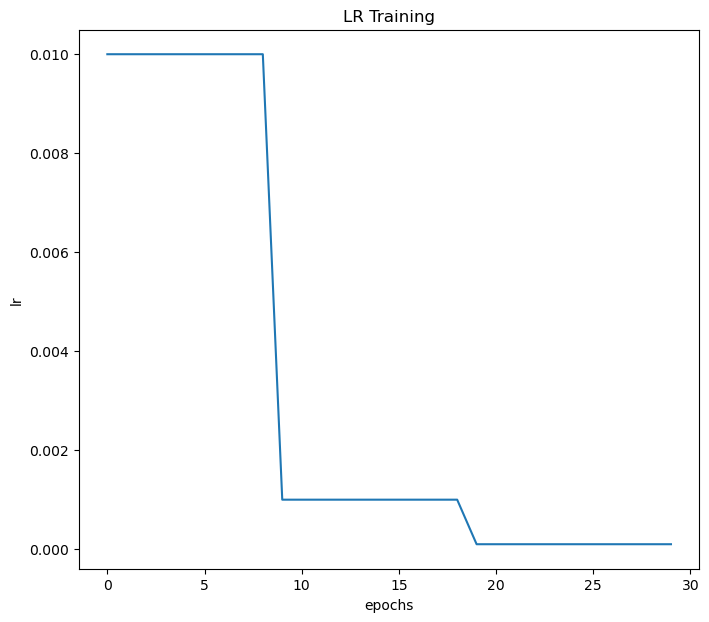

In [33]:
plt.figure(figsize = (8, 7))
plt.plot([train_history[e]['lr'] for e in train_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LR Training")
plt.show()

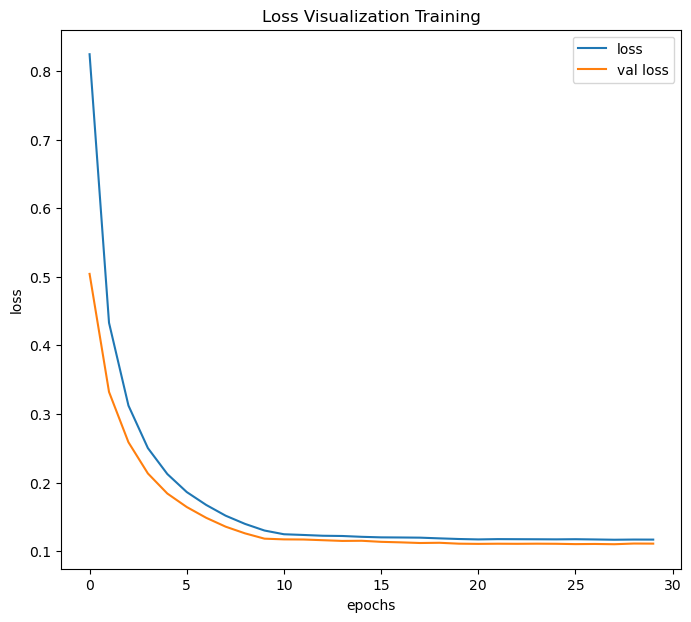

In [34]:
plt.figure(figsize = (8, 7))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss Visualization Training")
plt.legend(loc = 'best')
plt.show()

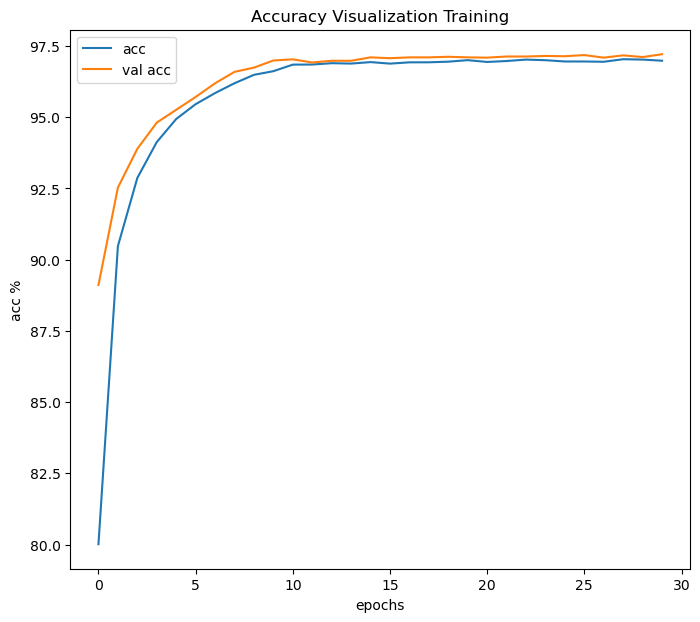

In [35]:
plt.figure(figsize = (8, 7))
plt.plot([train_history[e]['train_acc'] for e in train_history.keys()], label = 'acc')
plt.plot([train_history[e]['val_acc'] for e in train_history.keys()], label = 'val acc')
plt.xlabel("epochs")
plt.ylabel("acc %")
plt.title("Accuracy Visualization Training")
plt.legend(loc = 'best')
plt.show()

In [36]:
# Initialize and load trained parameters-
trained_model = LeNet5().to(device = device)
trained_model.load_state_dict(torch.load("LeNet5_MNIST_best_val_acc.pth"))

<All keys matched successfully>

In [38]:
val_loss, val_acc = test_one_step(
    model = trained_model, test_loader = test_loader,
    test_dataset = test_dataset
)
print(f"LeNet-5 'best' trained model: val loss = {val_loss:.4f} &"
      f" val acc = {val_acc:.2f}%")

Validation: : 100%|█| 40/40 [00:01<00:00, 33.51batch/s, val_acc=97.2, val_lo

LeNet-5 'best' trained model: val loss = 0.1110 & val acc = 97.21%


In [39]:
for layer_name, params in trained_model.named_parameters():
    print(f"{layer_name}, params.shape: {params.shape}")

conv1.weight, params.shape: torch.Size([6, 1, 5, 5])
bn1.weight, params.shape: torch.Size([6])
bn1.bias, params.shape: torch.Size([6])
conv2.weight, params.shape: torch.Size([16, 6, 5, 5])
bn2.weight, params.shape: torch.Size([16])
bn2.bias, params.shape: torch.Size([16])
fc1.weight, params.shape: torch.Size([120, 256])
fc1.bias, params.shape: torch.Size([120])
bn3.weight, params.shape: torch.Size([120])
bn3.bias, params.shape: torch.Size([120])
fc2.weight, params.shape: torch.Size([84, 120])
fc2.bias, params.shape: torch.Size([84])
bn4.weight, params.shape: torch.Size([84])
bn4.bias, params.shape: torch.Size([84])
fc3.weight, params.shape: torch.Size([10, 84])
fc3.bias, params.shape: torch.Size([10])


In [40]:
trained_model.conv1.weight.shape

torch.Size([6, 1, 5, 5])

In [41]:
# Compute L2-norm for each filter in conv layer-
for i in range(len(trained_model.conv1.weight)):
    print(f"filter: {i + 1}, l2-norm = {torch.norm(input = trained_model.conv1.weight[i], p = 2):.4f}")

filter: 1, l2-norm = 1.4670
filter: 2, l2-norm = 1.5785
filter: 3, l2-norm = 1.5208
filter: 4, l2-norm = 1.4626
filter: 5, l2-norm = 1.5640
filter: 6, l2-norm = 1.3949


In [42]:
# Compute L2 norm for all filters in first conv layer-
conv1_l2_norms = [torch.norm(input = trained_model.conv1.weight[i], p = 2).item() for i in range(len(trained_model.conv1.weight))]

In [43]:
conv1_l2_norms

[1.466958999633789,
 1.578518033027649,
 1.520751953125,
 1.4625601768493652,
 1.5639575719833374,
 1.3948670625686646]

In [44]:
# Sort conv filters according to L2 norms and get sorted indices-
torch.argsort(torch.tensor(conv1_l2_norms))

tensor([5, 3, 0, 2, 4, 1])